<a href="https://colab.research.google.com/github/maetthil/NASASpaceApps/blob/main/Read_CDF_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install cdflib
# !pip install spacepy
!pip install pyspedas
!pip install matplotlib

In [2]:
import cdflib 
import sys
import os
import requests
import pytz
import datetime
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm.notebook import tqdm


import pyspedas
from pytplot import tplot
import pytplot

In [20]:
#Mudei para baixar do satellite Dscovr
def download_bwt_file(year='2018'):
    url = f'https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h1/faraday_cup/{year}/'
    content = requests.get(url).content
    DATA_FOLDER = 'dataset/dscovr/'
    if not os.path.exists(DATA_FOLDER):
        os.mkdir(DATA_FOLDER)
    links = bs(content).findAll('a', href=True)
    print (f'Baixando arquivos de dados de {year}')
    for link in tqdm(links):
        filename = link['href']
        if filename.find('.cdf') < 0:
            continue
        response = requests.get(f'{url}{filename}')
        with open(f'{DATA_FOLDER}{filename}', 'wb') as f:
            f.write(response.content)

In [21]:
download_bwt_file()

Baixando arquivos de dados de 2018


  0%|          | 0/366 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [22]:
data_cdf = cdflib.CDF("/content/dataset/dscovr/dscovr_h1_fc_20180108_v08.cdf")

In [23]:
print(data_cdf)

In [24]:
# Verifica quais são as variaveis dentro do arquivo
data_info = data_cdf.cdf_info()
data_info

{'CDF': PosixPath('/content/dataset/dscovr/dscovr_h1_fc_20180108_v08.cdf'),
 'Version': '3.6.3',
 'Encoding': 6,
 'Majority': 'Column_major',
 'rVariables': [],
 'zVariables': ['Epoch',
  'Time_PB5',
  'format_time',
  'unit_time',
  'V_GSE',
  'cartesian',
  'label_V_GSE',
  'V_GSE_DELTA',
  'label_V_GSE_DELTA',
  'THERMAL_SPD',
  'THERMAL_SPD_DELTA',
  'Np',
  'Np_DELTA',
  'THERMAL_TEMP',
  'THERMAL_TEMP_DELTA',
  'DQF'],
 'Attributes': [{'Project': 'Global'},
  {'Source_name': 'Global'},
  {'Discipline': 'Global'},
  {'Data_type': 'Global'},
  {'Descriptor': 'Global'},
  {'File_naming_convention': 'Global'},
  {'Data_version': 'Global'},
  {'PI_name': 'Global'},
  {'PI_affiliation': 'Global'},
  {'TEXT': 'Global'},
  {'Instrument_type': 'Global'},
  {'Mission_group': 'Global'},
  {'Logical_source': 'Global'},
  {'Logical_file_id': 'Global'},
  {'Logical_source_description': 'Global'},
  {'Time_resolution': 'Global'},
  {'Rules_of_use': 'Global'},
  {'Generated_by': 'Global'},
  {'G

In [22]:
# Nesse caso queremos o campo magnético, B. Eles oferem nas coordenadas GSM, e GSE
# Acredito que para essa aplicação pode ser a GSM mesmo nesse momento

magnetic_field_gsm = data_cdf.varget("BGSM")
# São tres colunas, x, y e z
magnetic_field_gsm.shape

(937849, 3)

In [34]:
mag_field_dataframe = pd.DataFrame(magnetic_field_gsm, columns=["Bx_GSM", "Gy_GSM", "Bz_GSM"])

time = data_cdf.varget("Epoch")
mag_field_dataframe["Epoch"] = time

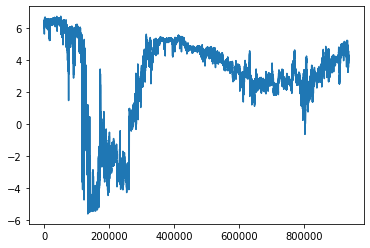

In [38]:
mag_field_dataframe["Gy_GSM"].plot()

Outra forma de Ler os arquivos (Acho mais Facil), é utilizando o modulo pyspedas, ele facilita o download e a leitura dos dados.

# Magnetometer (MAG)

In [3]:
# usando o pyspedas
mag_vars = pyspedas.dscovr.mag(trange=['2018-11-5', '2018-11-6'])

  ErfaWarning)



In [4]:
mag_vars

['dsc_h0_mag_B1F1',
 'dsc_h0_mag_B1SDF1',
 'dsc_h0_mag_B1GSE',
 'dsc_h0_mag_B1SDGSE',
 'dsc_h0_mag_B1RTN',
 'dsc_h0_mag_B1SDRTN']

In [5]:
# nesse caso presisamos algums passoa a mais para extrair as componentes
# Elas sao salvas no formato do pyspedas e para o pytplot

quants_Bgse = pytplot.data_quants['dsc_h0_mag_B1GSE']
quants_Bgse

<xarray.DataArray 'dsc_h0_mag_B1GSE' (time: 86400, v_dim: 3)>
array([[ 1.1943759 ,  3.0563607 ,  7.7736955 ],
       [ 1.0060904 ,  2.9633865 ,  7.7278194 ],
       [ 1.5659105 ,  2.4217308 ,  7.809438  ],
       ...,
       [-2.8408077 ,  1.3083203 , -0.23540872],
       [-2.8605602 ,  1.3098674 , -0.27897754],
       [-2.7993472 ,  1.322769  , -0.29635128]], dtype=float32)
Coordinates:
  * time     (time) float64 1.541e+09 1.541e+09 ... 1.541e+09 1.541e+09
Dimensions without coordinates: v_dim
Attributes:
    CDF:           {'VATT': {'FIELDNAM': 'Magnetic field vector in GSE cartes...
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...

In [6]:
# bx, by, bz
b_gsm = quants_Bgse.values
time = quants_Bgse.coords['time'].values
time_dt_b = [datetime.datetime.fromtimestamp(i, pytz.timezone("UTC")) for i in time]

In [7]:
dataframe_gse = pd.DataFrame(b_gsm, columns=["Bx_GSE", "Gy_GSE", "Bz_GSE"], index = time_dt_b)
dataframe_gse.head()

,Bx_GSE,Gy_GSE,Bz_GSE
2018-11-05 00:00:00.500000+00:00,1.194376,3.056361,7.773695
2018-11-05 00:00:01.500000+00:00,1.006090,2.963387,7.727819
2018-11-05 00:00:02.500000+00:00,1.565910,2.421731,7.809438
2018-11-05 00:00:03.500000+00:00,1.852083,2.311245,7.771448
2018-11-05 00:00:04.500000+00:00,1.205482,2.037003,7.789549


# Faraday Cup (FC)

In [17]:
pytplot.del_data()
fc_vars = pyspedas.dscovr.fc(trange=['2018-11-5', '2018-11-6'])

In [18]:
fc_vars

['dsc_h1_fc_V_GSE',
 'dsc_h1_fc_THERMAL_SPD',
 'dsc_h1_fc_Np',
 'dsc_h1_fc_THERMAL_TEMP']

In [9]:
quants_Vgse = pytplot.data_quants['dsc_h1_fc_V_GSE']
quants_thermalSpeed = pytplot.data_quants['dsc_h1_fc_THERMAL_SPD']
quants_Np = pytplot.data_quants['dsc_h1_fc_Np']
quants_thermalTemp = pytplot.data_quants['dsc_h1_fc_THERMAL_TEMP']

time_fc = quants_Vgse.coords['time'].values
time_fc_dt = [datetime.datetime.fromtimestamp(i, pytz.timezone("UTC")) for i in time_fc]
# tplot(['dsc_h1_fc_V_GSE', 'dsc_h1_fc_THERMAL_SPD', 'dsc_h1_fc_Np', 'dsc_h1_fc_THERMAL_TEMP'])

In [10]:
dataframe_fc = pd.DataFrame({"dsc_h1_fc_Vx_GSE":quants_Vgse[:,0], 
                             "dsc_h1_fc_Vy_GSE":quants_Vgse[:,1],
                             "dsc_h1_fc_Vz_GSE":quants_Vgse[:,2],
                             "dsc_h1_fc_THERMAL_SPD":quants_thermalSpeed.values, 
                             "dsc_h1_fc_Np":quants_Np.values, 
                             'dsc_h1_fc_THERMAL_TEMP':quants_thermalTemp.values}, index = time_fc_dt)
dataframe_fc.head()

,dsc_h1_fc_Vx_GSE,dsc_h1_fc_Vy_GSE,dsc_h1_fc_Vz_GSE,dsc_h1_fc_THERMAL_SPD,dsc_h1_fc_Np,dsc_h1_fc_THERMAL_TEMP
2018-11-05 00:00:00+00:00,-473.958740,11.917868,21.795387,68.390205,7.510447,283316.81250
2018-11-05 00:01:01+00:00,-476.043488,10.830706,19.726019,68.216896,7.552746,281882.71875
2018-11-05 00:02:01+00:00,-476.112701,1.879187,18.163383,67.262222,7.682232,274048.18750
2018-11-05 00:02:59+00:00,-476.207031,9.003065,22.759775,67.437187,7.538317,275475.75000
2018-11-05 00:04:00+00:00,-474.836334,12.154074,26.012655,67.979271,7.299348,279922.34375


<AxesSubplot:>

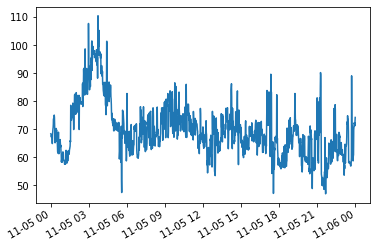

In [19]:
dataframe_fc["dsc_h1_fc_THERMAL_SPD"].plot()

# Wind Satellite
## Magnetic Field Investigation (MFI)

In [12]:
mfi_vars = pyspedas.wind.mfi(trange=['2018-11-5', '2018-11-6'])
mfi_Bgse = pytplot.data_quants['BGSE']

time = mfi_Bgse.coords['time'].values
time_dt_b_mfi = [datetime.datetime.fromtimestamp(i, pytz.timezone("UTC")) for i in time]

mfi_df = pd.DataFrame({"Bx_GSE": mfi_Bgse.values[:,0],
                       "By_GSE": mfi_Bgse.values[:,0],
                       "Bz_GSE": mfi_Bgse.values[:,0]}, index = time_dt_b_mfi)

## Solar Wind Experiment (SWE)

In [13]:
pytplot.del_data()
swe_vars = pyspedas.wind.swe(trange=['2018-11-5', '2018-11-6'])
swe_Ne = pytplot.data_quants['N_elec']
swe_Te = pytplot.data_quants['T_elec']

# Teste DTW

In [14]:
%%capture

!pip install dtaidistance

In [15]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [25]:
s1 = mfi_df["Bx_GSE"].head(100).values
s2 = dataframe_gse["Bx_GSE"].head(100).values
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

(None, None)

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

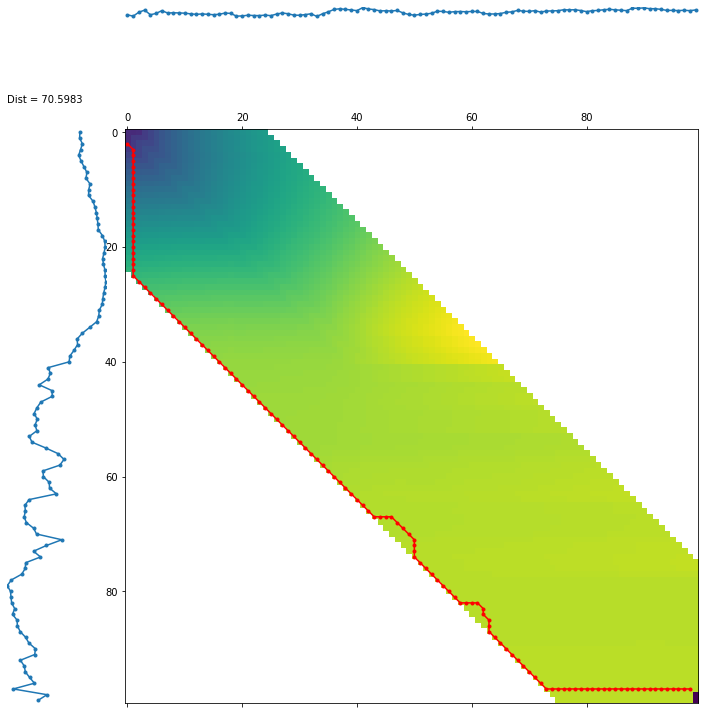

In [27]:
from dtaidistance import dtw_visualisation as dtwvis
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [26]:
s1

array([-7.55968332e+00, -7.51835346e+00, -7.90006113e+00, -7.65223598e+00,
       -7.39746380e+00, -7.72069502e+00, -8.11626816e+00, -8.51545143e+00,
       -8.37839794e+00, -8.93793488e+00, -8.76086617e+00, -8.73664856e+00,
       -9.33683586e+00, -9.60250568e+00, -9.79607868e+00, -9.91475773e+00,
       -1.00095396e+01, -1.00606995e+01, -1.06308537e+01, -1.09334230e+01,
       -1.09952250e+01, -1.08384809e+01, -1.06478710e+01, -1.07634144e+01,
       -1.09677267e+01, -1.09884233e+01, -1.10754614e+01, -1.09897385e+01,
       -1.07882462e+01, -1.06725101e+01, -1.05914640e+01, -1.01941185e+01,
       -1.01203079e+01, -9.83770561e+00, -8.88265610e+00, -7.90033913e+00,
       -7.19047785e+00, -7.23651218e+00, -6.75686216e+00, -6.18648863e+00,
       -6.09587193e+00, -3.26336980e+00, -3.54002976e+00, -3.21698856e+00,
       -2.04176712e+00, -3.74936152e+00, -3.81721282e+00, -2.25434446e+00,
       -1.71997440e+00, -1.34027731e+00, -1.77484035e+00, -1.46395767e+00,
       -1.71614635e+00, -